<a href="https://colab.research.google.com/github/karsarobert/DeepLearning2024/blob/main/04/PTE_DL4_ECG_ENG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning exercise


## Exercise 4: autoencoder nets
### 27 September 2023.

## Anomaly detection

## Overview


In this example, an autoencoder is trained to detect anomalies in the [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). This dataset contains 5000 [Electrocardiograms](https://en.wikipedia.org/wiki/Electrocardiography), each with 140 data points. You will use a simplified version of the dataset, where each example is labelled either `0` (corresponding to an abnormal rhythm) or `1` (corresponding to a normal rhythm). You are interested in identifying abnormal rhythms.

Note: This is a labelled data set, so it can be formulated as a supervised learning problem. The purpose of this example is to illustrate anomaly detection concepts that can be applied to larger datasets where labels are not available (for example, when there are many thousands of normal rhythms and only a small number of abnormal rhythms).

How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train the autoencoder only on normal rhythms and then use it to reconstruct all the data. Our hypothesis is that abnormal rhythms will have higher reconstruction error. It will then classify a rhythm as anomalous if the reconstruction error exceeds a fixed threshold.

Source: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb#scrollTo=Ndo4ERqnwQOU

Translated with DeepL.com (free version)

### Loading ECG data

The dataset is based on the database [timeseriesclassification.com] (http://www.timeseriesclassification.com/description.php?Dataset=ECG5000).

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses


In [ ]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [ ]:
# The last column contains labels,
labels = raw_data[:, -1]

# the other columns contain data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Data normalization `[0,1]`.




In [ ]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

You will train the autoencoder using only the normal ECG data, which has 1 label in the data set. Separate normal data from ECG data containing abnormal data.

In [ ]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels] #itt csak a True indexű adatokat választjuk ki
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels] # itt pedig a False cimkével rendelkezőket
anomalous_test_data = test_data[~test_labels]

Plotting a normal ECG

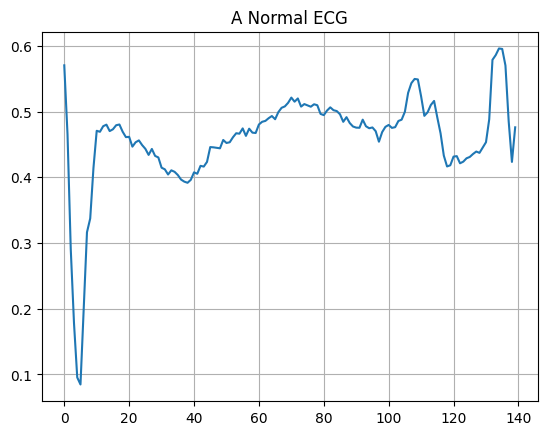

In [ ]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Plot an anomalous ECG.

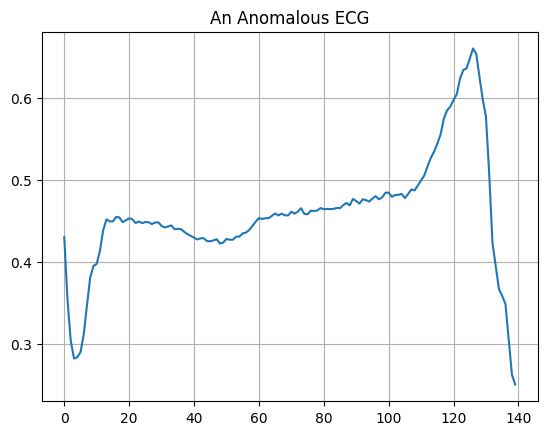

In [ ]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

# Structure of the model

In [ ]:
autoencoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu", kernel_initializer= 'he_normal', input_shape=(140,)),
      layers.Dense(16, activation="relu", kernel_initializer= 'he_normal'),
      layers.Dense(8, activation="relu", kernel_initializer= 'he_normal'), #bottleneck
      layers.Dense(16, activation="relu", kernel_initializer= 'he_normal'),
      layers.Dense(32, activation="relu", kernel_initializer= 'he_normal'),
      layers.Dense(140, activation="sigmoid")]) #


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

Note that the autoencoder is trained using the normal ECGs, but evaluated using the full test set.

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=50,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 254ms/step - loss: 0.0703 - val_loss: 0.0566
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0591 - val_loss: 0.0536
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0563 - val_loss: 0.0520
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0540 - val_loss: 0.0503
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0511 - val_loss: 0.0486
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0476 - val_loss: 0.0473
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0444 - val_loss: 0.0450
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0409 - val_loss: 0.0433
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0378 - val_loss: 0.0420
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0347 - val_loss: 0.0403
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0324 - val_loss: 0.0395
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0304 - val_loss: 0.0383


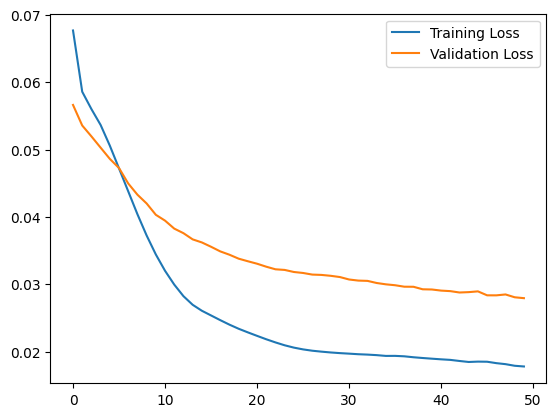

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In the following, we will classify an ECG as an anomaly if the reconstruction error is greater than one standard deviation from normal training examples. First, let us plot a normal ECG from the training set, the reconstruction after it has been encoded and decoded by the autocoder, and the reconstruction error.

Here we create an encoder and decoder using the original model!

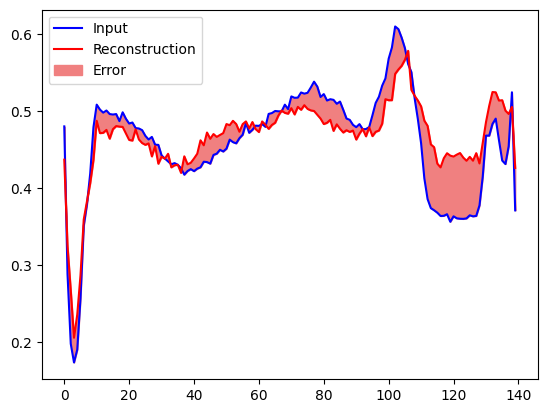

In [ ]:
decoded_data = autoencoder(normal_test_data).numpy()


plt.plot(normal_test_data[0], 'b') # a 0. test adatot kirajzoljuk
plt.plot(decoded_data[0], 'r') # a visszaállított adatot is kirajzoljuk
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

As before, we plot a data from the anomalous set

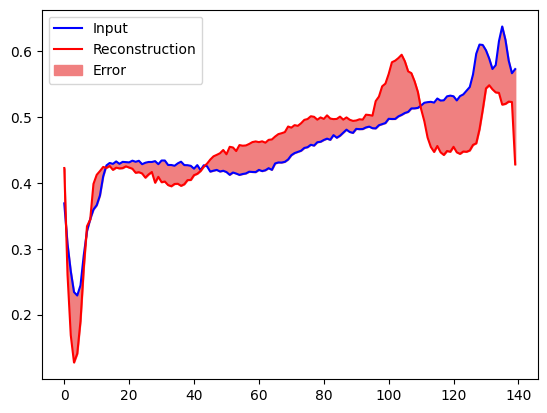

In [ ]:
decoded_data = autoencoder(anomalous_test_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Anomaly detection

Anomalies are detected by calculating whether the reconstruction loss is greater than a fixed threshold. First, the average mean error of the normal examples from the training set is calculated, and then future examples are classified as anomalous if the reconstruction error is greater than one standard deviation from the training set.

Representation of the reconstruction error on normal ECGs from the training set

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


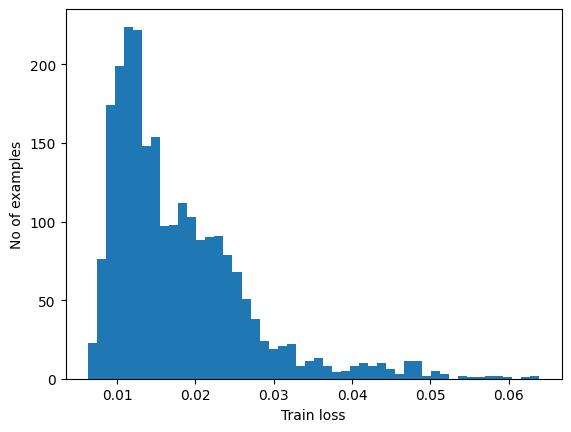

In [ ]:
reconstructions = autoencoder.predict(normal_train_data) # for the training set, we create the 'predictions' for the returned data
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data) # We then calculate their average absolute errors

plt.hist(train_loss[None,:], bins=50) # the distribution of the calculated average errors is plotted
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

We choose a threshold that is one standard deviation above the mean (mean + standard deviation)

In [ ]:
threshold = np.mean(train_loss) + 2*np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.03529380448162556


Note: Other strategies can be used to select the threshold above which test cases should be classified as anomalous, the correct approach depends on the dataset.

If you look at the reconstruction error of the anomalous examples in the test set, you will notice that in most cases the reconstruction error is larger than the threshold. By changing the threshold, you can adjust the [accuracy](https://developers.google.com/machine-learning/glossary#precision) and [recall](https://developers.google.com/machine-learning/glossary#recall) of the classifier.

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


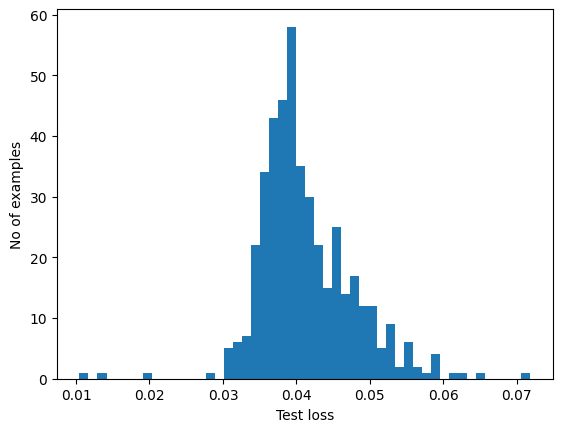

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

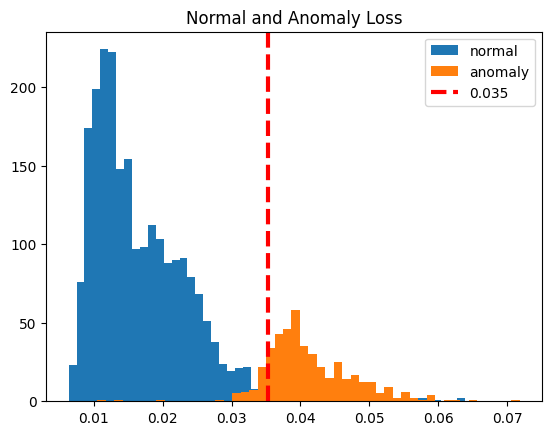

In [ ]:
plt.hist(train_loss, bins=50, label='normal')
plt.hist(test_loss, bins=50, label='anomaly')
plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))
plt.legend(loc='upper right')
plt.title("Normal and Anomaly Loss")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.921
Precision = 0.9125214408233276
Recall = 0.95


![](https://wikimedia.org/api/rest_v1/media/math/render/svg/7588abeafe63ab4b8ae63f954978186276e54d01)

![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/525px-Precisionrecall.svg.png)